# 80 tRNA chart with R²

In [1]:
import pickle as pkl
import numpy as np

from collections import Counter
from itertools import chain
import collections as col

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import pandas as pd
import shelve
#import dbm.gnu

from statsmodels.nonparametric.smoothers_lowess import lowess

Add translation to the `sys.path`:

In [2]:
import sys
sys.path.append(r'../')
sys.path.append(r'../translation/')

In [3]:
from translation.TRSL_specific import codon_anticodon, tRNA_types, chunker, complement

In [4]:
filepath = "../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20160906_1752_3600s.p"

In [5]:
results = pkl.load(open(filepath, "rb"), encoding='latin1')

In [6]:
filepath = "../results/ribosome_timecourses_updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20160906_1753.db"
d = shelve.open(filepath)

In [7]:
transcriptome = pkl.load(open('../parameters/transcriptome_shah.p', "rb"), encoding='latin1')
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p", "rb"), encoding='latin1')

In [8]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last to catch steady state
    # Select only every third element (the others are zero anyway):
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

In [9]:
# length of longest polysome in codons
max_codons = len(max(ribo_lattice_dict.values(), key=len))

# fill up with None values
for gene in ribo_lattice_dict:
    ribo_lattice_dict[gene] = np.append(ribo_lattice_dict[gene], \
                                        [None] * (max_codons - len(ribo_lattice_dict[gene])))

In [10]:
ribo_lattice_df = pd.DataFrame.from_dict(ribo_lattice_dict)

In [11]:
ribo_lattice_df_normalized = pd.DataFrame()

for column in ribo_lattice_df:
    ribo_lattice_df_normalized[column] = ribo_lattice_df[column]/float(transcriptome[column])

/tmp/ipykernel_138301/1418131119.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ribo_lattice_df_normalized[column] = ribo_lattice_df[column]/float(transcriptome[column])


In [12]:
sigmas = {gene: np.std(ribo_lattice_df_normalized[gene]) for gene in ribo_lattice_dict}
means = {gene: np.mean(ribo_lattice_df_normalized[gene]) for gene in ribo_lattice_dict}

In [13]:
threshold = 5  # this many standard deviations above the mean are required for a signal to be classified as a peak

peaks = {gene: [(pos, value, (value - means[gene]) / sigmas[gene]) for (pos, value) 
                in enumerate(ribo_lattice_df_normalized[gene]) if (value - means[gene]) / sigmas[gene] > threshold] 
         for gene in sigmas if sigmas[gene] != 0
         }
        # and gene in high_transcript_abundance_genes}  # delete this to include all genes

In [14]:
codons_at_peaks = {gene: [orf_genomic_dict[gene][elem[0]*3:elem[0]*3+3] for elem in peaks[gene]] for gene in peaks}
anticodons_at_peaks = {gene: [codon_anticodon[codon] for codon in codons_at_peaks[gene]]
                       for gene in codons_at_peaks}

def flatten_dict_values(dictionary):
    return list(chain(*dictionary.values()))

In [15]:
counter = Counter(flatten_dict_values(anticodons_at_peaks))

counter = col.OrderedDict(sorted(counter.items(), key=lambda t: t[1]))

In [16]:
anticodon_tRNA_abundancy = {tRNA_types[id]['anticodon']: tRNA_types[id]['abundancy'] for id in tRNA_types}

In [17]:
transcriptome_weighted_orfs = [orf_genomic_dict[gene] * transcriptome[gene] for gene in transcriptome 
                               if gene in orf_genomic_dict]

In [18]:
anticodon_demand_transcriptome = Counter([codon_anticodon[item] for sublist in [list(chunker(sequence, 3)) 
                                          for sequence in transcriptome_weighted_orfs] 
                                              for item in sublist])

## Calculation of R²

In [147]:
def corr_dict(dict1, dict2, logx=False, logy=False):
    keys = list(dict1.keys() & dict2.keys())
    if logx and logy:
        # print([np.log(dict1[y]) for y in keys])
        corr = np.corrcoef([np.log(dict1[x]) for x in keys], [np.log(dict2[y]) for y in keys])
    elif logx:
        corr = np.corrcoef([np.log(dict1[x]) for x in keys], [dict2[y] for y in keys])
    elif logy:
        corr = np.corrcoef([dict1[x] for x in keys], [np.log(dict2[y]) for y in keys])
    else:
        corr = np.corrcoef([dict1[x] for x in keys], [dict2[y] for y in keys])
    
    return corr[0, 1]

### Anticodon tRNA abundancy with peak counts (log)

In [40]:
dict1 = anticodon_tRNA_abundancy
dict2 = counter

In [41]:
corr_dict(dict1, dict2, logx=True, logy=True)

-0.3336767208252478

In [42]:
corr_dict(dict1, dict2, logx=True, logy=True)**2

0.11134015402069036

### Anticodon tRNA abundancy with anticodon demand in transcriptome (log)

In [43]:
dict1 = anticodon_tRNA_abundancy
dict2 = anticodon_demand_transcriptome

In [44]:
corr_dict(dict1, dict2, logx=True, logy=True)

0.8873008438233188

It was even higher for non-logarithmic values but I want to stay consistent.

In [45]:
corr_dict(dict1, dict2, logx=True, logy=True)**2

0.7873027874495735

## Plot

In [19]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [20]:
fontsize = 16

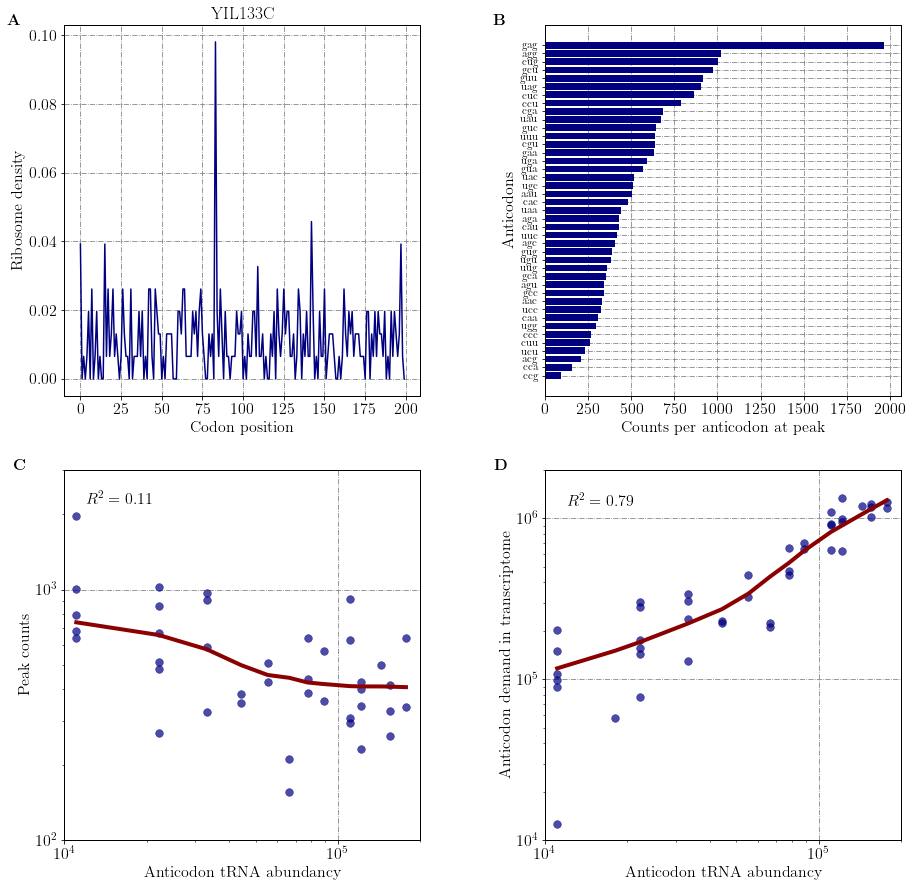

In [48]:
plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.labelcolor']='black'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['grid.linestyle']='-.'
plt.rcParams['grid.color']='grey'

hfont = {'fontname':'FreeSans'}

fig = plt.figure()
fig.subplots_adjust(wspace=0.35)
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['ytick.labelsize'] = 10

####################################################################
ax = fig.add_subplot(221, facecolor='white')

ax.plot(ribo_lattice_df_normalized["YIL133C"], color='navy')
ax.set_xlabel('Codon position', fontsize=fontsize, **hfont)
ax.set_ylabel('Ribosome density', fontsize=fontsize, **hfont)
plt.setp(ax.get_xticklabels(), fontsize=fontsize, **hfont)
plt.setp(ax.get_yticklabels(), fontsize=fontsize, **hfont)
ax.set_title("YIL133C", **hfont)
        
plt.text(-45, 0.103, r'\textbf{A}', fontsize=16, weight="bold", **hfont)

####################################################################
ax = fig.add_subplot(222, facecolor='white')

# make a horizontal bar chart
val = counter.values()    # the bar lengths
pos = np.arange(len(counter))+.5    # the bar centers on the y axis

plt.barh(pos, val, align='center', color='navy')
plt.yticks(pos, counter.keys())
plt.xlabel('Counts per anticodon at peak', fontsize=fontsize, **hfont)
plt.ylabel('Anticodons', fontsize=fontsize, **hfont)
plt.setp(ax.get_xticklabels(), fontsize=fontsize, **hfont)
plt.setp(ax.get_yticklabels(), fontsize=fontsize - 5, **hfont)
plt.grid(True)

plt.text(-300, 43, r'\textbf{B}', fontsize=16, weight="bold", **hfont)

####################################################################
ax = fig.add_subplot(223, facecolor='white')

dict1 = anticodon_tRNA_abundancy
dict2 = counter
xaxislabel = "Anticodon tRNA abundancy"
yaxislabel = "Peak counts"
fontsize = 16
alpha = 0.7


plotkeys = dict1.keys() & dict2.keys() # set intersection
xs = [dict1[key] for key in plotkeys]
ys = [dict2[key] for key in plotkeys] 

ax.grid(True, linestyle = '-.')
ax.set_xscale('log')
ax.set_yscale('log')
if xaxislabel:
    ax.set_xlabel(xaxislabel, **hfont)
    if fontsize:
        ax.set_xlabel(xaxislabel, fontsize=fontsize, **hfont)
        plt.setp(ax.get_xticklabels(), fontsize=fontsize, **hfont)
if yaxislabel:
    ax.set_ylabel(yaxislabel, **hfont)
    if fontsize:
        ax.set_ylabel(yaxislabel, fontsize=fontsize, **hfont)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize, **hfont)

scat = plt.scatter(xs, ys, s=60, color='navy')
scat.set_alpha(alpha)

points = zip(xs, ys)
sorted_points = sorted(points)
new_xs = [point[0] for point in sorted_points]
new_ys = [point[1] for point in sorted_points]
ylowess = lowess(new_ys, new_xs)[:,1]
plt.plot(new_xs, ylowess, 'darkred', linewidth=4)
plt.xlim([1e4, 2e5])
plt.ylim([1e2, 3e3])

plt.text(6.5e3, 3e3, r'\textbf{C}', fontsize=16, weight="bold", **hfont)
plt.text(1.2e4, 2.2e3, "$R^2 = 0.11$", fontsize=16, weight="bold")

####################################################################
ax = fig.add_subplot(224, facecolor='white')

dict1 = anticodon_tRNA_abundancy
dict2 = anticodon_demand_transcriptome
xaxislabel = "Anticodon tRNA abundancy"
yaxislabel = "Anticodon demand in transcriptome"
fontsize=16
alpha = 0.7


plotkeys = dict1.keys() & dict2.keys() # set intersection
xs = [dict1[key] for key in plotkeys]
ys = [dict2[key] for key in plotkeys] 

ax.grid(True, linestyle = '-.')
ax.set_xscale('log')
ax.set_yscale('log')
if xaxislabel:
    ax.set_xlabel(xaxislabel, **hfont)
    if fontsize:
        ax.set_xlabel(xaxislabel, fontsize=fontsize, **hfont)
        plt.setp(ax.get_xticklabels(), fontsize=fontsize, **hfont)
if yaxislabel:
    ax.set_ylabel(yaxislabel, **hfont)
    if fontsize:
        ax.set_ylabel(yaxislabel, fontsize=fontsize, **hfont)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize, **hfont)

scat = plt.scatter(xs, ys, s=60, color='navy')
scat.set_alpha(alpha)

points = zip(xs, ys)
sorted_points = sorted(points)
new_xs = [point[0] for point in sorted_points]
new_ys = [point[1] for point in sorted_points]
ylowess = lowess(new_ys, new_xs)[:,1]
plt.plot(new_xs, ylowess, 'darkred', linewidth=4)
plt.xlim([1e4, 2e5])
plt.ylim([1e4, 2e6])

plt.text(6.5e3, 2e6, r'\textbf{D}', fontsize=16, weight="bold", **hfont)
plt.text(1.2e4, 1.2e6, "$R^2 = 0.79$", fontsize=16, weight="bold")

plt.savefig('ribosome_stalling.pdf', bbox_inches='tight')

## Figure 2

In [87]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein']
for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

In [88]:
prot_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_speeds[prot] > 100: 
        print(prot, prot_speeds[prot])

YJL189W 115.66034482762224
YLR110C 108.31024771541968
YKL152C 115.56526237143666
YKL060C 145.47675153749
YOL086C 117.69469509745605
YCR012W 112.14782458765491
YAL038W 122.93809989083661
YLR044C 193.17040229891074


In [89]:
prot_per_transcript_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_per_transcript_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / \
        transcriptome[prot] / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_per_transcript_speeds[prot] > 0.25: 
        print(prot, prot_per_transcript_speeds[prot])

In [90]:
transcript_tic_toc = {transcript.index: transcript.tic_toc for transcript in results['transcriptome']}

In [101]:
transcript_tic_toc_averages = {index: np.mean([toc-tic for (tic, toc) in transcript_tic_toc[index]]) for index in transcript_tic_toc}
transcript_df = pd.DataFrame(pd.Series(transcript_tic_toc_averages))
transcript_df.columns = ['tic_toc']

/home/mjs/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mjs/.local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [102]:
transcript_df

,tic_toc
0,60.600000
1,58.642553
2,59.177778
3,59.425532
4,59.129167
...,...
57503,27.207547
57504,27.043810
57505,26.713208
57506,26.900000


In [103]:
temp_df = pd.DataFrame(pd.Series({transcript.index: transcript.geneID for transcript in results['transcriptome']}))
temp_df.columns = ['geneID']

In [104]:
temp_df

,geneID
0,YBR177C
1,YBR177C
2,YBR177C
3,YBR177C
4,YBR177C
...,...
57503,YLR192C
57504,YLR192C
57505,YLR192C
57506,YLR192C


In [105]:
transcript_df = pd.merge(transcript_df, temp_df, left_index=True, right_index=True, how='outer')

In [106]:
transcript_df

,tic_toc,geneID
0,60.600000,YBR177C
1,58.642553,YBR177C
2,59.177778,YBR177C
3,59.425532,YBR177C
4,59.129167,YBR177C
...,...,...
57503,27.207547,YLR192C
57504,27.043810,YLR192C
57505,26.713208,YLR192C
57506,26.900000,YLR192C


In [107]:
gene_tic_toc = transcript_df.groupby('geneID').mean().to_dict()['tic_toc']
gene_tic_toc_df = pd.DataFrame.from_dict(gene_tic_toc.items())
gene_tic_toc_df.columns = ['name', 'tic toc [s]']

In [110]:
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

In [111]:
df1 = pd.DataFrame.from_dict(orf_lengths.items())
df1.columns = ['name', 'ORF length [nts]']

In [112]:
df = pd.merge(gene_tic_toc_df, df1, left_on='name', right_on='name', how='outer')

In [114]:
ribo_speed_dict = {geneID: orf_lengths[geneID]/3.0/gene_tic_toc[geneID] for geneID in gene_tic_toc}

In [125]:
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None, fontsize=None, alpha=0.2, filename=None):
    plotkeys = dict1.keys() & dict2.keys() # set intersection
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    # fig =  plt.figure()                

    # ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '0.75')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    scat = plt.scatter(xs, ys, alpha=0.8, color='red', edgecolor='lightcoral', linewidth=1)
    scat.set_alpha(alpha)

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points]
    new_ys = [point[1] for point in sorted_points]
    ylowess = lowess(new_ys, new_xs)[:,1]
    plt.plot(new_xs, ylowess, 'royalblue', linewidth=4)
    
    #if filename:
    #    plt.savefig(filename, bbox_inches='tight')

    #plt.show()

### R² berechnen

ORF length with time to finish protein:

In [155]:
df.corr()
#corr_dict(df['ORF length [nts]'].to_dict(), df['tic toc [s]'].to_dict(), logx=True, logy=True)

,tic toc [s],ORF length [nts]
tic toc [s],1.000000,0.974273
ORF length [nts],0.974273,1.000000


In [156]:
0.974273**2

0.9492078785289999

Transcriptome with prot_speeds:

In [129]:
corr_dict(transcriptome, prot_speeds, logx=True, logy=True)

0.9509504072070316

In [130]:
corr_dict(transcriptome, prot_speeds, logx=True, logy=True)**2

0.9043066769672192

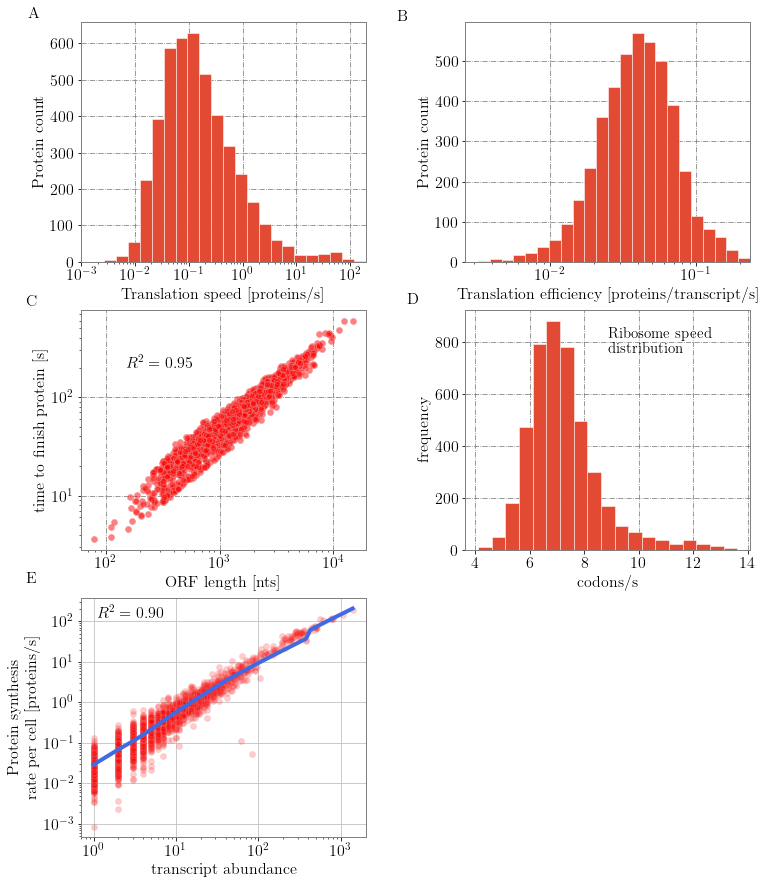

In [158]:
plt.rcParams['figure.figsize'] = (12, 15)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'grey'

fig = plt.figure()
fig.subplots_adjust(wspace=0.35)

ax = fig.add_subplot(321)
n, bins, patches = ax.hist(prot_speeds.values(), 
                           bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                  np.log10(max(prot_speeds.values())), 25), 
                           edgecolor='white')
ax.set_xscale("log")
ax.set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
ax.set_xlabel('Translation speed [proteins/s]', fontsize=16)
ax.set_ylabel('Protein count', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.text(0.0001, 670, "A", fontsize=16, weight="bold")

ax = fig.add_subplot(322)
n, bins, patches = ax.hist(prot_per_transcript_speeds.values(), 
                           bins = 10**np.linspace(np.log10(min(prot_per_transcript_speeds.values())+0.0001), 
                                                  np.log10(max(prot_per_transcript_speeds.values())), 32), 
                           edgecolor='white')
ax.set_xscale("log")
ax.set_xlim([min(prot_per_transcript_speeds.values())+0.002, max(prot_per_transcript_speeds.values())])
ax.set_xlabel('Translation efficiency [proteins/transcript/s]', fontsize=16)
ax.set_ylabel('Protein count', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.text(0.0009, 600, "B", fontsize=16, weight="bold")


ax = fig.add_subplot(323)
ax.scatter(df['ORF length [nts]'], df['tic toc [s]'], alpha=0.5, color='red', edgecolor='lightcoral', linewidth=1)
ax.set_xlabel('ORF length [nts]', fontsize=16)
ax.set_ylabel('time to finish protein [s]', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_yscale('log')
ax.set_xscale('log')

plt.text(20, 850, "C", fontsize=16, weight="bold")
plt.text(1.5e2, 200, "$R^2 = 0.95$", fontsize=16)

ax = fig.add_subplot(324)
plt.hist(ribo_speed_dict.values(), bins=np.arange(min(ribo_speed_dict.values()), max(ribo_speed_dict.values()), 0.5),
         edgecolor='white')
ax.set_xlabel('codons/s', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
plt.setp(plt.gca().get_xticklabels(), fontsize=16)
plt.setp(plt.gca().get_yticklabels(), fontsize=16)

plt.text(1.5, 950, "D", fontsize=16, weight="bold")
#plt.title("") #, weight="bold")
ax.text(.5, .82, 'Ribosome speed\ndistribution', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

ax = fig.add_subplot(325)
scatter_dicts(transcriptome, prot_speeds, "transcript abundance", 
             "Protein synthesis\nrate per cell [proteins/s]",
             fontsize = 16)
plt.text(0.15, 900, "E", fontsize=16, weight="bold")
plt.text(1.1, 125, "$R^2 = 0.90$", fontsize=16)

#plt.show()
plt.savefig('translation_efficiencies_3_by_2.pdf', bbox_inches='tight')